### This notebook is aimming to predict redshift using predicted magnitude using bliss. In total, three prepration steps are needed:
1. train regression network \
    a. run f"{home}/case_studies/redshift/preprocess_dataset.sh" \
    b. run f"{home}/case_studies/redshift/train.sh" 
2. train bliss model. \
    a. run f"{home}/bliss/case_studies/dc2/run_dc2_exp.sh"
    b. run  jupyter notebook at /home/qiaozhih/bliss/case_studies/redshift/redshift_from_predicted_mag/DC2_mag_predict.ipynb to get df_bliss & df_true


In [3]:
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn

In [4]:
num_bins = 1
group_size = 128
batch_size = 512
in_dim = 6
device = "cuda"
path = "/home/qiaozhih/bliss/case_studies/redshift/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

In [5]:
reg = PhotoZFromMag(
    in_dim,
    network_options["hidden_dim"],
    network_options["out_dim"],
    network_options["dropout_rate"],
    network_options["learning_rate"],
    network_options["loss_fcn"],
)
reg = reg.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

PhotoZFromMag(
  (loss_fcn): MSELoss()
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

# PhotozFrom GT

In [6]:
dataset_name = "bliss_true_mag"
path = f"/home/qiaozhih/bliss/data/redshift/dc2/{dataset_name}.pkl"
photo_z = pd.read_pickle(path)
print("finish reading dataset!")
device = "cuda"


print("start tensor dataset preparation!")
x = photo_z.values[:, :-1].astype(float)
y = photo_z.values[:, -1].astype(float)
n_samples, n_features_x = x.shape
n_features_y = 1
n_samples = n_samples // group_size * group_size

x_train = np.array(x[:n_samples])
y_train = np.array(y[:n_samples])
tensor_x = torch.Tensor(x_train).view(-1, group_size, n_features_x)
tensor_y = torch.Tensor(y_train).view(-1, group_size, n_features_y)
tensor_x = torch.Tensor(x_train)
tensor_y = torch.Tensor(y_train)
custom_dataset = TensorDataset(tensor_x, tensor_y)
dataloader = DataLoader(custom_dataset, batch_size=batch_size)

finish reading dataset!
start tensor dataset preparation!


In [7]:
preds = []
trues = []
reg.eval()
with torch.no_grad():
    for idx, (x, y) in tqdm(enumerate(dataloader), unit="batch"):
        x = x.to(device)
        y = y.to(device)
        pred_this_batch = reg.net(x)
        preds.append(pred_this_batch)
        trues.append(y)

        if idx > 10000:
            break

28batch [00:01, 26.05batch/s]


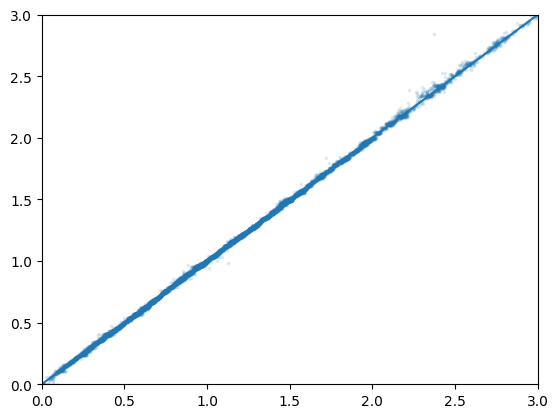

In [8]:
preds = torch.cat(preds)
trues = torch.cat(trues)
preds = preds.reshape(-1, 1)
trues = trues.reshape(-1, 1)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axline((0, 0), slope=1)
preds = preds.detach().cpu().numpy()
trues = trues.detach().cpu().numpy()
plt.scatter(preds, trues, alpha=0.1, s=3)

In [9]:
mse = mean_squared_error(trues, preds)
print(f"mse:{mse:03f}")

mse:0.000134


# PhotozFrom Bliss

In [10]:
dataset_name = "bliss_pred_mag"
path = f"/home/qiaozhih/bliss/data/redshift/dc2/{dataset_name}.pkl"
photo_z = pd.read_pickle(path)
print("finish reading dataset!")
device = "cuda"


print("start tensor dataset preparation!")
x = photo_z.values[:, :-1].astype(float)
y = photo_z.values[:, -1].astype(float)
n_samples, n_features_x = x.shape
n_features_y = 1
n_samples = n_samples // group_size * group_size

x_train = np.array(x[:n_samples])
y_train = np.array(y[:n_samples])
tensor_x = torch.Tensor(x_train).view(-1, group_size, n_features_x)
tensor_y = torch.Tensor(y_train).view(-1, group_size, n_features_y)
tensor_x = torch.Tensor(x_train)
tensor_y = torch.Tensor(y_train)
custom_dataset = TensorDataset(tensor_x, tensor_y)
dataloader = DataLoader(custom_dataset, batch_size=batch_size)

finish reading dataset!
start tensor dataset preparation!


In [12]:
preds = []
trues = []
reg.eval()
with torch.no_grad():
    for idx, (x, y) in tqdm(enumerate(dataloader), unit="batch"):
        x = x.to(device)
        y = y.to(device)
        pred_this_batch = reg.net(x)
        preds.append(pred_this_batch)
        trues.append(y)

        if idx > 10000:
            break

28batch [00:00, 160.06batch/s]


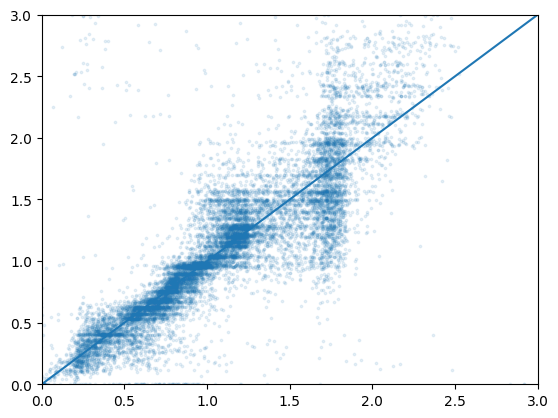

In [13]:
preds = torch.cat(preds)
trues = torch.cat(trues)
preds = preds.reshape(-1, 1)
trues = trues.reshape(-1, 1)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axline((0, 0), slope=1)
preds = preds.detach().cpu().numpy()
trues = trues.detach().cpu().numpy()
plt.scatter(preds, trues, alpha=0.1, s=3)

In [14]:
mse = mean_squared_error(trues, preds)
print(f"mse:{mse:03f}")

mse:0.094575
